In [12]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from rff.layers import GaussianEncoding #pip install random-fourier-features-pytorch
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os
import optuna
from optuna.trial import TrialState
from tab_transformer_pytorch import FTTransformer
import time

In [13]:
# Run regardless if you do or do not have GPU so all tensors are moved to right location later on
if torch.cuda.is_available():
    device_in_use = torch.device("cuda")
    print("GPU is available and being used")
else:
    device_in_use = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used


# LOAD AND PROCESS DATA
**EXAMPLE WITH Income**

In [14]:
df_train = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/income/train.csv')
df_test = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/income/test.csv')
df_val = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/income/validation.csv') #READ FROM RIGHT SPOT

# df_train = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\income\train.csv')
# df_test = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\income\test.csv')
# df_val = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\income\validation.csv') #READ FROM RIGHT SPOT

#Take a look at what the datasets look like initially to get an idea
df_train.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [15]:
cont_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week']
cat_columns = ['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country']
target = ['income']

#CHECKING TO MAKE SURE YOUR LIST IS CORRECT (NO NEED TO TOUCH)
yourlist = cont_columns + cat_columns+target
yourlist.sort()
oglist = list(df_train.columns)
oglist.sort()

assert(yourlist == oglist), "You may of spelled feature name wrong or you forgot to put on of them in the list"


In [16]:
#Get class counts and store in a list below

for x in cat_columns:
    print(max(len(df_train[x].value_counts()), len(df_val[x].value_counts()), len(df_test[x].value_counts())))

10
16
7
16
6
5
2
43


In [17]:
# Manually enter class counts in the same order
cat_features = (10,16,7,16,6,5,2,43)

In [18]:
#Getting the number of classes in your classification target
target_classes = [max(len(df_train[target].value_counts()), len(df_val[target].value_counts()),len(df_test[target].value_counts()))]
target_classes = target_classes[0]

In [19]:
# Create a StandardScaler and fit it to the cont features
scaler = StandardScaler()
scaler.fit(df_train[cont_columns])

# Transform the training, test, and validation datasets
df_train[cont_columns] = scaler.transform(df_train[cont_columns])
df_test[cont_columns] = scaler.transform(df_test[cont_columns])
df_val[cont_columns] = scaler.transform(df_val[cont_columns])

In [20]:
class SingleTaskDataset(Dataset):
    def __init__(self, df : pd.DataFrame, cat_columns, num_columns,task1_column):
        self.n = df.shape[0]
        
        self.task1_labels = df[task1_column].astype(np.float32).values

        self.cate = df[cat_columns].astype(np.int64).values
        self.num = df[num_columns].astype(np.float32).values


    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        # Retrieve features and labels from the dataframe using column names
        cat_features = self.cate[idx]
        num_features = self.num[idx]
        labels_task1 = self.task1_labels[idx]

        return cat_features, num_features, labels_task1

#Wrapping in Dataset
train_dataset = SingleTaskDataset(df_train, cat_columns, cont_columns, 'income')
val_dataset = SingleTaskDataset(df_val, cat_columns, cont_columns, 'income')
test_dataset = SingleTaskDataset(df_test, cat_columns, cont_columns, 'income')

#This is a hyperparameter that is not tuned. Maybe mess with what makes sense here
#Also try looking to see what other papers have done
batch_size = 256

# Wrapping with DataLoader for easy batch extraction
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [21]:
# each task loss is scaled by its own learnable parameter, then regularization is applied 
class LossFunctions(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunctions, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions
        loss_fn = self.loss_fns[0]
        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
# Training and Testing Loops
def train(dataloader, model, loss_function, optimizer, device_in_use):
    model.train()

    total_loss = 0
    total_correct_1 = 0
    total_samples_1 = 0
    all_targets_1 = []
    all_predictions_1 = []

    for (categorical, numerical, labels_task1) in dataloader:
        categorical, numerical, labels_task1 = categorical.to(device_in_use), numerical.to(device_in_use), labels_task1.to(device_in_use)
        
        #running them through model and modifying the shape slightly for the loss function
        task_predictions = model(categorical, numerical)
        task_predictions = task_predictions.squeeze(1)
        
        loss = loss_function(task_predictions, labels_task1)
        total_loss += loss.item()
        
        #computing accuracy for first target
        y_pred_softmax_1 = torch.softmax(task_predictions, dim=1)
        _, y_pred_labels_1 = torch.max(y_pred_softmax_1, dim=1)
        total_correct_1 += (y_pred_labels_1 == labels_task1).sum().item()
        total_samples_1 += labels_task1.size(0)
        all_targets_1.extend(labels_task1.cpu().numpy())
        all_predictions_1.extend(y_pred_labels_1.cpu().numpy())


        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss/len(dataloader)
    accuracy_1 = total_correct_1 / total_samples_1

    return avg_loss, accuracy_1

def test(dataloader, model, loss_function, device_in_use):
    model.eval()
    total_loss = 0
    
    total_loss = 0
    total_correct_1 = 0
    total_samples_1 = 0
    all_targets_1 = []
    all_predictions_1 = []

    with torch.no_grad():
        for (categorical, numerical, labels_task1) in dataloader:
            categorical, numerical, labels_task1 = categorical.to(device_in_use), numerical.to(device_in_use), labels_task1.to(device_in_use)
            
            #running them through model and modifying the shape slightly for the loss function
            task_predictions = model(categorical, numerical)
            task_predictions = task_predictions.squeeze(1)
            loss = loss_function(task_predictions, labels_task1)
            total_loss += loss.item()
            
            #computing accuracy for first target
            y_pred_softmax_1 = torch.softmax(task_predictions, dim=1)
            _, y_pred_labels_1 = torch.max(y_pred_softmax_1, dim=1)
            total_correct_1 += (y_pred_labels_1 == labels_task1).sum().item()
            total_samples_1 += labels_task1.size(0)
            all_targets_1.extend(labels_task1.cpu().numpy())
            all_predictions_1.extend(y_pred_labels_1.cpu().numpy())

    avg = total_loss/len(dataloader)
    accuracy_1 = total_correct_1 / total_samples_1
    f1_1 = f1_score(all_targets_1, all_predictions_1, average='weighted')

    return avg, accuracy_1, all_predictions_1, all_targets_1, f1_1

def format_metric(value): # Used to format the metrics output
    return f"{value:.4f}"


Epoch [ 1/100]       | Train: Loss 0.4209, Accuracy 0.7942                               | Test: Loss 0.3209, Accuracy 0.8536, F1 0.8473
Epoch [ 2/100]       | Train: Loss 0.3145, Accuracy 0.8547                               | Test: Loss 0.3121, Accuracy 0.8584, F1 0.8529
Epoch [ 3/100]       | Train: Loss 0.3079, Accuracy 0.8569                               | Test: Loss 0.3128, Accuracy 0.8563, F1 0.8494
Epoch [ 4/100]       | Train: Loss 0.3050, Accuracy 0.8571                               | Test: Loss 0.3075, Accuracy 0.8561, F1 0.8494
Epoch [ 5/100]       | Train: Loss 0.3033, Accuracy 0.8586                               | Test: Loss 0.3085, Accuracy 0.8558, F1 0.8467
Epoch [ 6/100]       | Train: Loss 0.3030, Accuracy 0.8579                               | Test: Loss 0.3069, Accuracy 0.8603, F1 0.8560
Epoch [ 7/100]       | Train: Loss 0.3009, Accuracy 0.8592                               | Test: Loss 0.3157, Accuracy 0.8559, F1 0.8448
Epoch [ 8/100]       | Train: Loss 0.3000

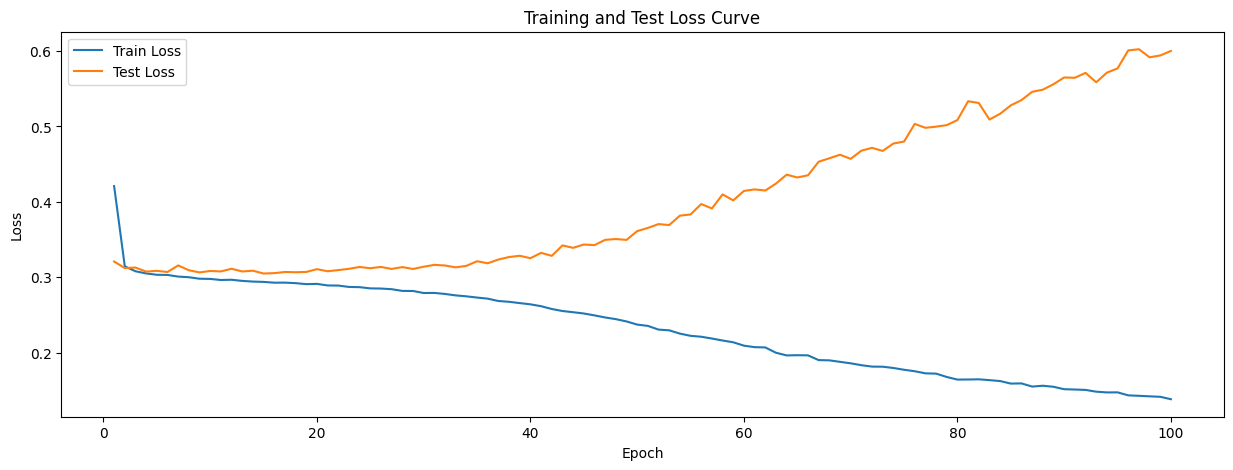

In [22]:
#Testing against the test dataset
model = FTTransformer(categories=cat_features,
                          num_continuous=len(cont_columns),
                          dim=192,
                          depth=3,
                          heads=8,
                          dim_out=target_classes,
                          attn_dropout=0.2,
                          ff_dropout=0.1).to(device_in_use)
loss_functions = LossFunctions(1)
optimizer = torch.optim.AdamW(params=model.parameters(), lr = 0.0001, weight_decay=0.00001)
epochs = 100

train_losses = []
train_accuracies_1 = [] 

test_losses = []
test_accuracies_1 = []
  
test_f1_scores = [] 
all_attention_scores = []

#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 1, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")